In [47]:
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', None) # Display all columns
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import numpy as np
from sklearn.model_selection import train_test_split
import missingno as msno
from sklearn.impute import SimpleImputer

In [24]:
raw_data_dir = Path(Path.cwd().parent, "data", "raw")
input_fname = Path(raw_data_dir, "dataset.csv")
df = pd.read_csv(input_fname, low_memory=False)

# Tran Test Split
Before I undertake any data cleaning or transformation I'll put aside a test set for final model performance. 
I intend to use cross validation during training to evaluate the model iteratively, so don't need to set aside a validation set at this point. 

Due to the high imbalance present in the target feature, seen in the previous notebook, it is important the train test split is stratified. 

In [25]:
perc_pos_prior = 100*(df['CHURN'].value_counts()[1] / len(df)) # % positive target feature prior to splitting
perc_pos_prior

0.67

In [26]:
X = df.drop('CHURN', axis = 1)
y = df['CHURN']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y) # 80:20 train:test split

In [27]:
y_train_unique, y_train_counts = np.unique(y_train, return_counts=True)
y_test_unique, y_test_counts = np.unique(y_test, return_counts=True)

perc_pos_post_train = y_train_counts[1]/ (sum(y_train_counts)) * 100
perc_pos_post_test = y_train_counts[1]/ (sum(y_train_counts)) * 100

print(f"% of positive target features in y_train: {perc_pos_post_train } %")
print(f"% of positive target features in y_train: {perc_pos_post_test} %")

assert np.isclose(a = perc_pos_post_train,b =  perc_pos_prior)
assert np.isclose(a = perc_pos_post_test,b =  perc_pos_prior)


% of positive target features in y_train: 0.67 %
% of positive target features in y_train: 0.67 %


Now we have a stratified train test split we can put aside the test set for future use. 

# Cleaning and Transformation

In [28]:
X.head()

,SALESFORCEACCOUNTID,ACCOUNTING_MONTH,RENEWAL_MONTH,CONTRACT_START_DATE,REGION,SECTOR,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,ARR,SEATS,COMPETITOR_SEATS,DETECTEDSEATSCOUNT,PRODUCT_ONE,PRODUCT_TWO,PRODUCT_THREE,PRODUCT_FOUR,PRODUCT_FIVE,PRODUCT_SIX,PRODUCT_SEVEN,PRODUCT_EIGHT,PRODUCT_NINE,PRODUCT_TEN,PRODUCT_ELEVEN,PRODUCT_TWELVE,PRODUCT_THIRTEEN,PRODUCT_FOURTEEN,PRODUCT_FIFTEEN,PRODUCT_SIXTEEN,PRODUCT_SEVENTEEN,PRODUCT_EIGHTEEN,PRODUCT_NINETEEN,PRODUCT_TWENTY,PRODUCT_TWENTYONE,PRODUCT_TWENTYTWO,PRODUCT_TWENTYTHREE,LICENSINGSPECIALIST_CHANGE,SALESREP_CHANGE,UPSELLMANAGER_CHANGE,ACCOUNTMANAGER_CHANGE,CHURN_RISK_DISCUSSION,CUSTOMER_HEALTH_CHECK,CS_EVENT_ATTENDED,CROSS_SELL_RECENCY,SEATS_DOWNSELL_RECENCY,PRODUCT_DOWNSELL_RECENCY,SEATS_UPSELL_RECENCY,PCT_PRODUCT_TWO_ENABLED,PCT_PRODUCT_THREE_ENABLED,PCT_PRODUCT_FOUR_ENABLED,PCT_PRODUCT_FIVE_ENABLED,PCT_PRODUCT_SIX_ENABLED,PCT_PRODUCT_NINE_ENABLED,PCT_PRODUCT_TWO_BEST_PRACTICE,PCT_PRODUCT_THREE_BEST_PRACTICE,PCT_PRODUCT_FOUR_BEST_PRACTICE,CUSTOMER_BEHAVIOUR_ONE,CUSTOMER_BEHAVIOUR_TWO,CUSTOMER_BEHAVIOUR_THREE,CUSTOMER_BEHAVIOUR_FOUR,CUSTOMER_BEHAVIOUR_FIVE,CUSTOMER_BEHAVIOUR_SIX,CUSTOMER_BEHAVIOUR_SEVEN,CUSTOMER_BEHAVIOUR_EIGHT,CUSTOMER_BEHAVIOUR_NINE,CUSTOMER_BEHAVIOUR_TEN,CUSTOMER_BEHAVIOUR_ELEVEN,MAX_SUPPORT_CASE_DAYSTOCLOSE,MAX_SUPPORT_CASE_TIMETOFIRSTRESPONSE,AVG_SUPPORT_CASE_PRIORITY_SCORE,SUM_SEVERE_CASES,SUM_HIGH_CASES,SUM_MEDIUM_CASES,SUM_LOW_CASES,SUM_STANDARD_CASES,SUPPORT_CASE_NUMBEROFSLABREACHES,BACKLOG,SURVEY_AVG_CXI_SCORE,SURVEY_AVG_NPS_SCORE,SURVEY_AVG_CASE_MOOD_SCORE
0,0011N00001hBZM7QAO,2021-10-01 00:00:00+00:00,2021-12-01T00:00:00Z,2020-12-24T00:00:00Z,UKI,Professional Services,126,NaN,NaN,364,27241.17,330,0,1.015152,1,1,1,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,21,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,NaN,NaN,NaN
1,0011N00001hBZM7QAO,2021-11-01 00:00:00+00:00,2021-12-01T00:00:00Z,2020-12-24T00:00:00Z,UKI,Professional Services,127,NaN,NaN,364,27241.17,330,0,1.021212,1,1,1,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,22,7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,NaN,NaN,NaN
2,0011N00001hBZM7QAO,2021-12-01 00:00:00+00:00,2022-12-01T00:00:00Z,2021-12-24T00:00:00Z,UKI,Professional Services,128,NaN,NaN,364,30349.76,350,0,0.940000,1,1,1,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,NaN,NaN,NaN
3,0011N00001hBZM7QAO,2022-01-01 00:00:00+00:00,2022-12-01T00:00:00Z,2021-12-24T00:00:00Z,UKI,Professional Services,129,NaN,NaN,364,30349.76,350,0,0.960000,1,1,1,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,1,0,0,0,0,0,0,0,0,0,0,116598,0,0,0,11525,362,4,14,1892,0,0,0,0.0,0,0,0,0,0,0,1,NaN,NaN,NaN
4,0011N00001hBZM7QAO,2022-02-01 00:00:00+00:00,2022-12-01T00:00:00Z,2021-12-24T00:00:00Z,UKI,Professional Services,130,NaN,NaN,364,30349.76,350,0,0.940000,1,1,1,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,25,2,0,0,0,0,0,0,0,0,0,0,40704,0,0,0,3804,194,17,4,737,0,0,0,0.0,0,0,0,0,0,0,1,NaN,NaN,NaN


In [29]:
X.columns

Index(['SALESFORCEACCOUNTID', 'ACCOUNTING_MONTH', 'RENEWAL_MONTH',
       'CONTRACT_START_DATE', 'REGION', 'SECTOR', 'TENURE_MONTHS',
       'DNB_GLOBAL_SALES_REVENUE', 'DNB_GLOBAL_EMPLOYEE_COUNT',
       'CONTRACT_LENGTH', 'ARR', 'SEATS', 'COMPETITOR_SEATS',
       'DETECTEDSEATSCOUNT', 'PRODUCT_ONE', 'PRODUCT_TWO', 'PRODUCT_THREE',
       'PRODUCT_FOUR', 'PRODUCT_FIVE', 'PRODUCT_SIX', 'PRODUCT_SEVEN',
       'PRODUCT_EIGHT', 'PRODUCT_NINE', 'PRODUCT_TEN', 'PRODUCT_ELEVEN',
       'PRODUCT_TWELVE', 'PRODUCT_THIRTEEN', 'PRODUCT_FOURTEEN',
       'PRODUCT_FIFTEEN', 'PRODUCT_SIXTEEN', 'PRODUCT_SEVENTEEN',
       'PRODUCT_EIGHTEEN', 'PRODUCT_NINETEEN', 'PRODUCT_TWENTY',
       'PRODUCT_TWENTYONE', 'PRODUCT_TWENTYTWO', 'PRODUCT_TWENTYTHREE',
       'LICENSINGSPECIALIST_CHANGE', 'SALESREP_CHANGE', 'UPSELLMANAGER_CHANGE',
       'ACCOUNTMANAGER_CHANGE', 'CHURN_RISK_DISCUSSION',
       'CUSTOMER_HEALTH_CHECK', 'CS_EVENT_ATTENDED', 'CROSS_SELL_RECENCY',
       'SEATS_DOWNSELL_RECENCY', 'PRODUC

# Cleaning
## Handling missing data

In [30]:
X.isnull().sum().sort_values().tail(10)

PRODUCT_TWELVE                    0
PRODUCT_ELEVEN                    0
PRODUCT_SEVENTEEN                 0
ACCOUNTING_MONTH                  0
SECTOR                        15070
DNB_GLOBAL_EMPLOYEE_COUNT     38137
DNB_GLOBAL_SALES_REVENUE      38137
SURVEY_AVG_CASE_MOOD_SCORE    97556
SURVEY_AVG_CXI_SCORE          98810
SURVEY_AVG_NPS_SCORE          99635
dtype: int64

<Axes: >

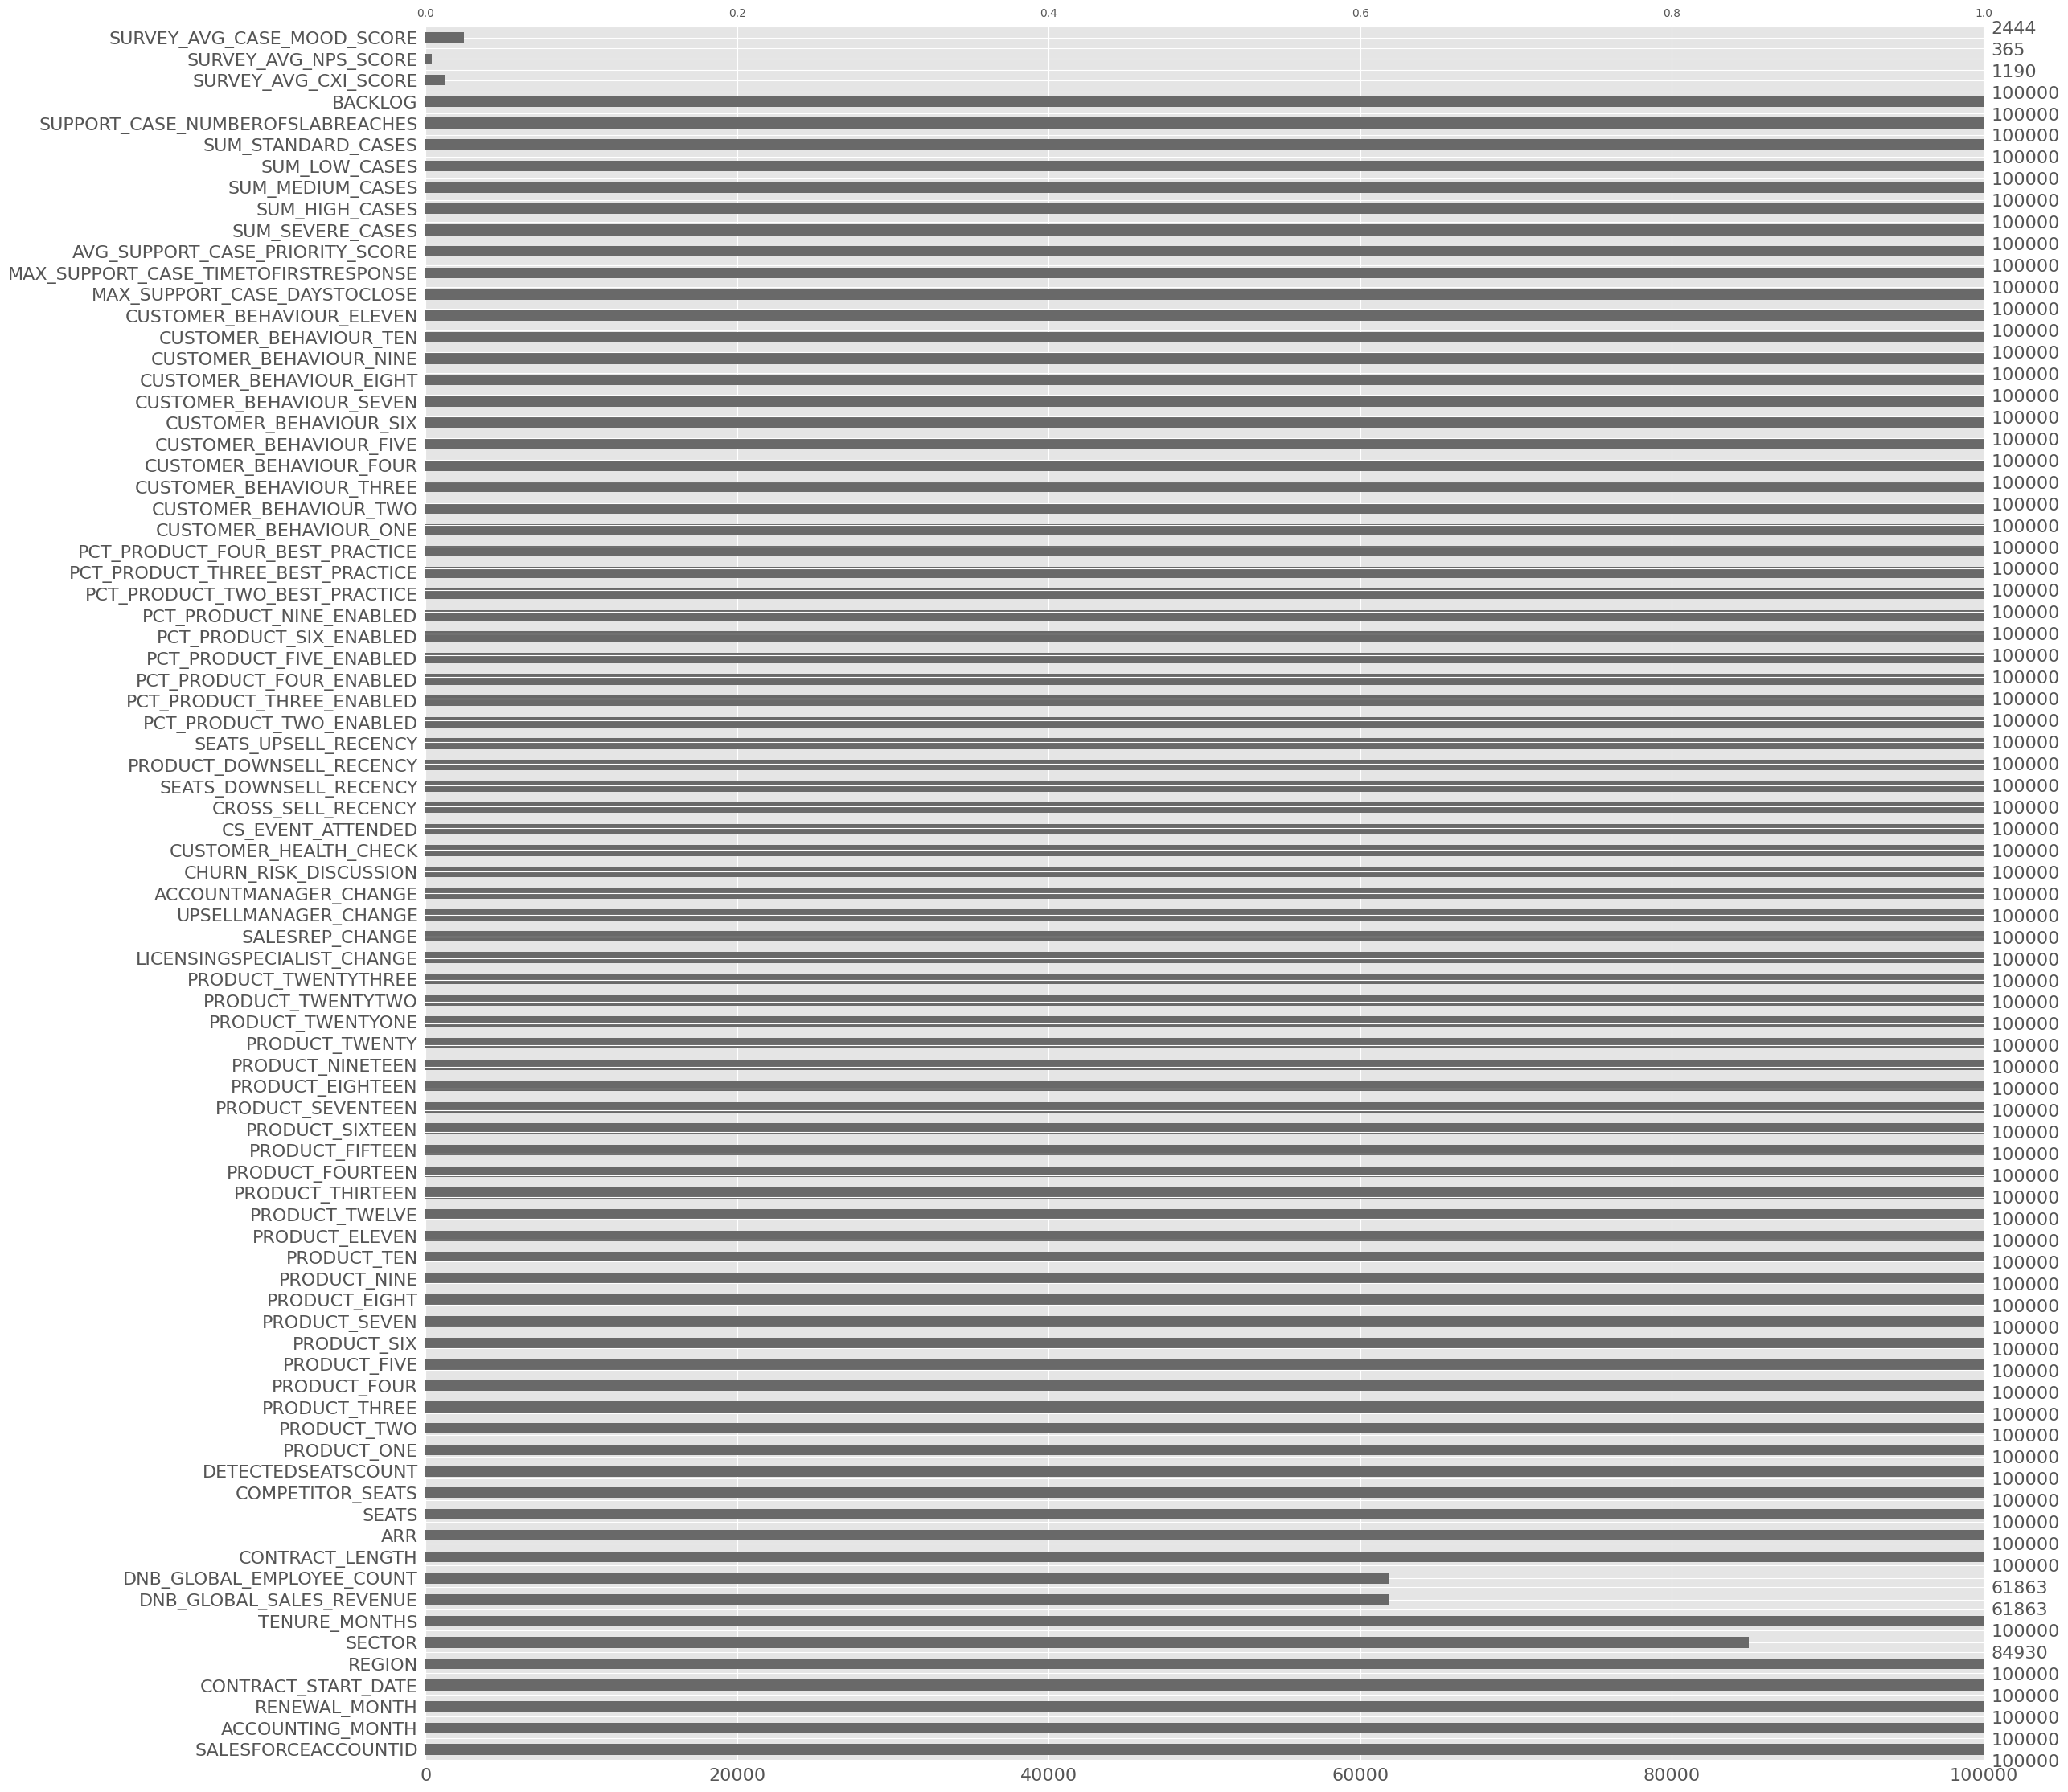

In [31]:
msno.bar(X)

"SURVEY_AVG_CXI_SCORE", "SURVEY_AVG_NPS_SCORE", and "SURVEY_AVG_CASE_MOOD_SCORE" have very little data, only around 360 - 2500 values for the entire dataset (100,000 points). Due to the severe lack of data here it makes most sense to just drop these columns from the dataset. 

In [32]:
X = X.drop(["SURVEY_AVG_CXI_SCORE", "SURVEY_AVG_NPS_SCORE", "SURVEY_AVG_CASE_MOOD_SCORE"], axis = 1)

The other columns with missing data - "SECTOR", "DNB_GLOBAL_EMPLOYEE_COUNT", and "DNB_GLOBAL_SALES_REVENUE" have more available data (around 65 - 80% complete) and so may be able to be imputed, I'm going to investigate the definition of these columns and check what makes sense. From the instructions:

SECTOR - Customer's sector

DNB_GLOBAL_EMPLOYEE_COUNT - Global employee count (third-party data)

DNB_GLOBAL_SALES_REVENUE - Global sales revenue (third-party data)

### Employee Count imputation

In [41]:
X.select_dtypes('number').corr()['DNB_GLOBAL_EMPLOYEE_COUNT'].sort_values()

PRODUCT_NINE                -0.092084
PRODUCT_ONE                 -0.073002
PRODUCT_FIVE                -0.063114
PRODUCT_TWO                 -0.032556
PRODUCT_EIGHTEEN            -0.027450
                               ...   
SEATS                        0.107954
DNB_GLOBAL_SALES_REVENUE     0.773809
DNB_GLOBAL_EMPLOYEE_COUNT    1.000000
PRODUCT_TWENTYONE                 NaN
PRODUCT_TWENTYTWO                 NaN
Name: DNB_GLOBAL_EMPLOYEE_COUNT, Length: 72, dtype: float64

Employee count is highly correlated with Sales revenue. This could be useful for imputing however based on the bar plot above we can see that these two features are missing together, likely due to a failing on the part of the third part data collection. 
Let's check the distribution of this columns to see if we should impute with mean or median. 

<Axes: xlabel='DNB_GLOBAL_EMPLOYEE_COUNT', ylabel='Count'>

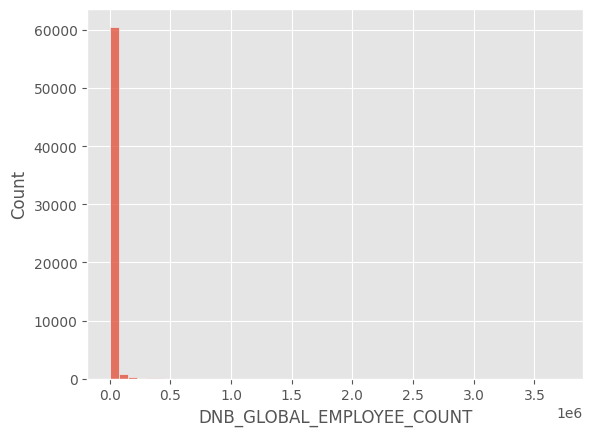

In [44]:
sns.histplot(data = X, x = 'DNB_GLOBAL_EMPLOYEE_COUNT', bins = 50)

In [45]:
X['DNB_GLOBAL_EMPLOYEE_COUNT'].describe()

count    6.186300e+04
mean     7.569068e+03
std      7.891647e+04
min      2.000000e+00
25%      7.900000e+01
50%      2.600000e+02
75%      1.092000e+03
max      3.715221e+06
Name: DNB_GLOBAL_EMPLOYEE_COUNT, dtype: float64

As the distribution is extremely right tailed imputing I will impute with the median for now. 

In [54]:
imputer = SimpleImputer(strategy = 'median')
employee_count_imputed_vals = imputer.fit_transform(X['DNB_GLOBAL_EMPLOYEE_COUNT'].values.reshape(-1,1))
X['DNB_GLOBAL_EMPLOYEE_COUNT'] = employee_count_imputed_vals


### Sales Revenue imputation

In [56]:
X.select_dtypes('number').corr()['DNB_GLOBAL_SALES_REVENUE'].sort_values()

PRODUCT_NINE                -0.095160
PRODUCT_ONE                 -0.078036
PRODUCT_FIVE                -0.065100
PRODUCT_NINETEEN            -0.035499
PRODUCT_SIX                 -0.030838
                               ...   
ARR                          0.225338
DNB_GLOBAL_EMPLOYEE_COUNT    0.773809
DNB_GLOBAL_SALES_REVENUE     1.000000
PRODUCT_TWENTYONE                 NaN
PRODUCT_TWENTYTWO                 NaN
Name: DNB_GLOBAL_SALES_REVENUE, Length: 72, dtype: float64

Same idea as before, since we have no clear correlation with other features I will investigate the frequency and imputer with either mean or median

<Axes: xlabel='DNB_GLOBAL_SALES_REVENUE', ylabel='Count'>

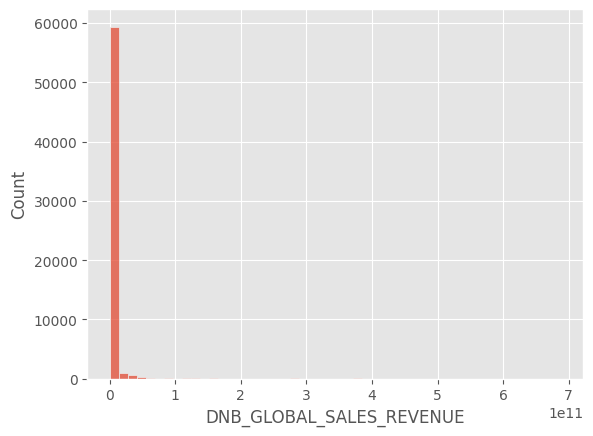

In [57]:
sns.histplot(data = X, x = 'DNB_GLOBAL_SALES_REVENUE', bins = 50)

In [58]:
employee_count_imputed_vals = imputer.fit_transform(X['DNB_GLOBAL_SALES_REVENUE'].values.reshape(-1,1))
X['DNB_GLOBAL_SALES_REVENUE'] = employee_count_imputed_vals

### Sector Imputation

"Sector" is a categorical feature and so can't be imputed with the mean or median. There are several techniques to handling missing categorical features:
1. Delete the rows with missing data
2. Create a new observation titled "Missing"
3. Fill the most frequent observation

Rows with missing "Sector" data represent around 15% of the entire dataset, so I dont want to delete these and lose a lot of valueable information. 
Similarly missing these in with the mose frequency (mode) value will likely create an over represenation of this class. 
In this case I think the best way to fill these is with a new "missing" example. 

In [65]:
X['SECTOR']= X['SECTOR'].fillna('missing')

That should be all of our missing data handled, either dropped completely or imputed, let's check:

In [67]:
X.isnull().sum().sum()

0